In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import argparse

# Hyperparameters

parser = argparse.ArgumentParser()

parser.add_argument("--in_channels",      type=int,   default=3,   help="number of channels on input")
parser.add_argument("--out_channels",     type=int,   default=3,   help="number of channels on output")

parser.add_argument("--unet_out_f",       type=int,   default=64,  help="n of filters in the last conv layer of unet")
parser.add_argument("--unet_conv_kernel", type=int,   default=4,   help="kernel size on unet conv layers")
parser.add_argument("--unet_conv_stride", type=int,   default=2,   help="stride on unet conv layers")
parser.add_argument("--unet_conv_pad",    type=int,   default=1,   help="padding on unet conv layers")
parser.add_argument("--unet_dropout",     type=float, default=0.5, help="dropout rate on unet")
parser.add_argument("--unet_lrelu_slope", type=float, default=0.2, help="slope of leaky relu on unet")

parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')

hps = parser.parse_args()

CIFAR-10 for dummy tests.

In [4]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

n_bins = 2**8  # 8 bits

transform = transforms.Compose([transforms.ToTensor(), 
                         lambda x: x + torch.zeros_like(x).uniform_(0., 1./n_bins)])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./.data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./.data', train=False,
                                       download=True, transform=transform)

    
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=10, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=10, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class UnetLayer(nn.Module):
    
    def __init__(self, hps, input_c, inner_f, outer_f, layer_type, sublayer, dropout=False):
        
        """
        Parameters:
            input_c (int)        : number of input channels
            inner_f (int)        : number of filters on inner layer
            outer_f (int)        : number of filters on outer layer
            layer_type (str)     : type of this layer, either 'default', 'innermost' or 'outermost'
            sublayer (UnetLayer) : sublayer in unet-hierarchy
            dropout (bool)       : use dropout layer?
        """
        
        super(UnetLayer, self).__init__()
        
        self.layer_type = layer_type
        
        down_conv = nn.Conv2d(input_c, inner_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
        down_relu = nn.LeakyReLU(hps.unet_lrelu_slope, inplace=True)
        down_norm = nn.BatchNorm2d(inner_f)
        
        up_relu = nn.ReLU(inplace=True)
        up_norm = nn.BatchNorm2d(outer_f)
        
        # Layers that are not innermost or outermost
        if layer_type == "default":
            up_conv = nn.ConvTranspose2d(inner_f * 2, outer_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
            downlayers = [down_conv, down_relu, down_norm]
            uplayers = [up_conv, up_relu, up_norm]
            
            if dropout:
                layer = downlayers + [sublayer] + uplayers + [nn.Dropout(hps.unet_dropout)]
            else:
                layer = downlayers + [sublayer] + uplayers
            
        if layer_type == "outermost":
            up_conv = nn.ConvTranspose2d(inner_f * 2, outer_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
            downlayers = [down_conv]
            uplayers = [up_conv, up_relu, nn.Tanh()]
            layer = downlayers + [sublayer] + uplayers
            
        if layer_type == "innermost":
            up_conv = nn.ConvTranspose2d(inner_f, outer_f, kernel_size=hps.unet_conv_kernel,
                              stride=hps.unet_conv_stride, padding=hps.unet_conv_pad)
            downlayers = [down_conv, down_relu]
            uplayers = [up_conv, up_relu, up_norm]
            layer = downlayers + uplayers
        
        self.layer = nn.Sequential(*layer) 
        
        
    def forward(self, input):
        
        if self.layer_type == "outermost":
            return self.layer(input)
        else:
            return torch.cat([input, self.layer(input)], 1)
        
        

In [6]:
class Unet(nn.Module):
    """
    U-net (O. Ronneberger, P. Fischer, and T. Brox. (2015)) is utilized for generator.

    """
    def __init__(self, hps, input_c, output_c, outer_f, depth, dropout=False):
        
        """
        Parameters:
        
            input_c (int)  : number of input channels
            output_c (int) : number of output channels
            outer_f (int)  : number of filters on the last convolution
            depth (int)    : number of unet layers
            dropout (bool) : use dropout layer?
        """
        
        super(Unet, self).__init__()
        
        # Recursive construction:
        
        # Innermost layer
        layers = UnetLayer(hps, 8*outer_f, 8*outer_f, 8*outer_f, "innermost", None)
        
        # Default layers
        for i in range(depth - 5):
            layers = UnetLayer(hps, 8*outer_f, 8*outer_f, 8*outer_f, "default", layers, dropout=dropout)
        for i in range(3):
            # Gradual reduction of number of filters
            layers = UnetLayer(hps, (8//2**(i+1))*outer_f, (8//2**i)*outer_f, (8//2**(i+1))*outer_f, "default", layers)
        
        # Outermost layer
        self.layers = UnetLayer(hps, input_c, outer_f, output_c, "outermost", layers)
        
    def forward(self, input):
        return self.layers(input)
        

In [7]:
# Test forward pass with upsampled cifar-10

from torch.autograd import Variable

G = Unet(hps, hps.in_channels, hps.out_channels, 64, 7, True)

u = torch.nn.Upsample(scale_factor=4)

x, _ = trainset[0]
x = x.unsqueeze(0)
x = Variable(x)
x = u(x)

y = G(x)
y.shape


torch.Size([1, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


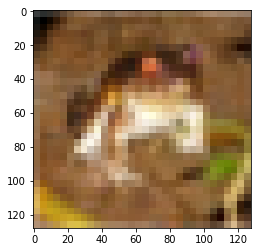

In [10]:
import matplotlib.pyplot as plt
x = x.squeeze(0)
plt.imshow(x.permute(1, 2, 0))

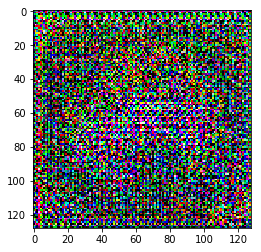

In [11]:
y = y.squeeze(0).detach()
plt.imshow(y.permute(1, 2, 0))